In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import lightgbm as lgb
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])

available GPU devices: 1  | device num: 0


In [2]:
DATA_DIR = './data'
MODELS_DIR = './models'
MODEL_VER = 'v0'
BACKWARD_LAGS = 60
CUT_DATE = '2012-01-01'
VAL_DATE = '2016-04-01'
END_DATE = '2016-04-24'
print(datetime.strptime(END_DATE, '%Y-%m-%d'))
#-----|CUT_DATE|---train---|VAL_DATE|--val--|END_DATE|--forecast +28 days-->

2016-04-24 00:00:00


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int16', 
    'month':            'int16', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int16', 
    'snap_TX':          'int16', 
    'snap_WI':          'int16'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float32'
}

In [4]:
def get_df(is_train=True, backward_lags=None):
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    cat_cols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    last_day = int(strain.columns[-1].replace('d_', ''))
    print('last day is:', last_day)
    if not is_train:
        for day in range(last_day + 1, last_day + 29):
            strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = cat_cols,
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    print('calendar merge done')
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    strain = strain.merge(
        sprices, 
        on=['store_id', 'item_id', 'wm_yr_wk'], 
        copy=False
    )
    print('prices merge done')
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    if not is_train:
        strain = strain.loc[
            strain['date'] >= (datetime.strptime(END_DATE, '%Y-%m-%d') - timedelta(days=backward_lags))
        ]
    else:
        strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    return strain

In [5]:
def make_features(strain):
    print('in dataframe:', strain.shape)
    lags = [7, 28]
    windows= [7, 28]
    wnd_feats = [
        'id', 
        'item_id', 
        #'dept_id', 
        #'store_id', 
        #'cat_id', 
        #'state_id'
    ]
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby('id')['sales'].shift(lag)
    print('lag sales done')
    for wnd_feat in wnd_feats:
        for wnd in windows:
            for lag_col in lag_cols:
                wnd_col = '{}_{}_rmean_{}'.format(lag_col, wnd_feat, wnd)
                strain[wnd_col] = strain[[wnd_feat, lag_col]].groupby(wnd_feat)[lag_col].transform(
                    lambda x: x.rolling(wnd).mean()
                )
        print('rolling mean sales for feature done:', wnd_feat)
    date_features = {
        'week_num': 'weekofyear',
        'quarter': 'quarter',
        'mday': 'day'
    }
    for date_feat_name, date_feat_func in date_features.items():
        strain[date_feat_name] = getattr(strain['date'].dt, date_feat_func).astype('int16')
    print('date features done')
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('out dataframe:', strain.shape)
    return strain

In [28]:
def lgbm_proc(strain, cat_cols):
    strain[cat_cols] = strain[cat_cols].fillna(0)
    for col in tqdm(cat_cols):
        strain[col]= strain[col].astype('category')
        strain[col] = strain[col].cat.codes.astype('int16')
        strain[col] -= strain[col].min()
    return strain

In [6]:
%%time
strain = get_df(is_train=True, backward_lags=None)

read train: (30490, 1919)
last day is: 1913
melted train: (58327370, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-04-24 00:00:00
date cut train: (40919927, 22)
cut train date: 2012-01-01 00:00:00
end train date: 2016-04-24 00:00:00
CPU times: user 38.8 s, sys: 6.58 s, total: 45.4 s
Wall time: 45.4 s


In [7]:
%%time
strain = make_features(strain)

in dataframe: (40919927, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (40919927, 35)
CPU times: user 2min 2s, sys: 8.32 s, total: 2min 10s
Wall time: 2min 10s


from 2012-01-01 00:00:00 to 2016-04-24 00:00:00


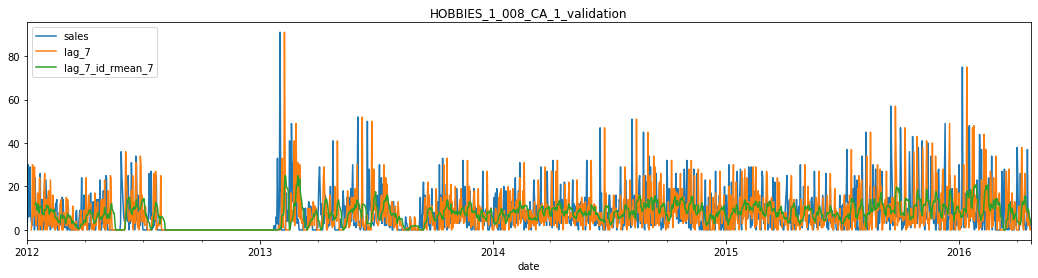

In [8]:
id_name = 'HOBBIES_1_008_CA_1_validation'
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_7'].plot(label='lag_7')
id_sales['lag_7_id_rmean_7'].plot(label='lag_7_id_rmean_7')
#id_sales['lag_7_store_id_rmean_7'].plot(label='lag_7_store_id_rmean_7')
#id_sales['lag_7_cat_id_rmean_7'].plot(label='lag_7_cat_id_rmean_7')
plt.title(id_name)
plt.legend()
plt.show()

In [9]:
drop_cols = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday']
train_cols = strain.columns[~strain.columns.isin(drop_cols)]
cat_cols = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    #'year', 'wday', 'month', 'quarter',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]
strain = lgbm_proc(strain, cat_cols)

In [10]:
%%time
val_size = int(strain.shape[0] * .15)
val_idxs = np.random.choice(strain.index.values, val_size, replace=False)
train_idxs = np.setdiff1d(strain.index.values, val_idxs)
X_train = strain.loc[train_idxs][train_cols]
y_train = strain.loc[train_idxs]['sales']
X_val = strain.loc[val_idxs][train_cols]
y_val = strain.loc[val_idxs]['sales']
print('train shapes:', X_train.shape, len(y_train))
print('val shapes:', X_val.shape, len(y_val))
train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)

train shapes: (34781938, 30) 34781938
val shapes: (6137989, 30) 6137989
CPU times: user 16.8 s, sys: 1.55 s, total: 18.4 s
Wall time: 18.4 s


In [11]:
del X_train, y_train, X_val, y_val, val_idxs, train_idxs
gc.collect()

187

In [12]:
%%time
params = {
    'objective' : 'poisson',
    'metric' :'rmse',
    'force_row_wise' : True,
    'learning_rate' : .075,
    #'sub_feature' : .8,
    'sub_row' : .75,
    'bagging_freq' : 1,
    'lambda_l2' : .1,
    #'nthread' : 4
    'metric': ['rmse'],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    'min_data_in_leaf': 100,
}
model = lgb.train(params, train_lgb, valid_sets=[val_lgb], verbose_eval=20) 

/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 2.94573
[40]	valid_0's rmse: 2.61004
[60]	valid_0's rmse: 2.52319
[80]	valid_0's rmse: 2.49822
[100]	valid_0's rmse: 2.48527
[120]	valid_0's rmse: 2.47634
[140]	valid_0's rmse: 2.46681
[160]	valid_0's rmse: 2.45626
[180]	valid_0's rmse: 2.44799
[200]	valid_0's rmse: 2.44024
[220]	valid_0's rmse: 2.4332
[240]	valid_0's rmse: 2.42878
[260]	valid_0's rmse: 2.42359
[280]	valid_0's rmse: 2.42025
[300]	valid_0's rmse: 2.41443
[320]	valid_0's rmse: 2.40964
[340]	valid_0's rmse: 2.40616
[360]	valid_0's rmse: 2.40267
[380]	valid_0's rmse: 2.39928
[400]	valid_0's rmse: 2.39477
[420]	valid_0's rmse: 2.39124
[440]	valid_0's rmse: 2.38796
[460]	valid_0's rmse: 2.38482
[480]	valid_0's rmse: 2.38203
[500]	valid_0's rmse: 2.37831
[520]	valid_0's rmse: 2.37521
[540]	valid_0's rmse: 2.37395
[560]	valid_0's rmse: 2.37123
[580]	valid_0's rmse: 2.36881
[600]	valid_0's rmse: 2.36656
[620]	valid_0's rmse: 2.36396
[640]	valid_0's rmse: 2.36185
[660]	valid_0's rmse: 2.36008
[680]	valid_0's

In [13]:
model.save_model('{}/model_{}.lgb'.format(MODELS_DIR, MODEL_VER))

In [29]:
model = lgb.Booster(model_file='{}/model_{}.lgb'.format(MODELS_DIR, MODEL_VER))

In [30]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.feature_importance())],
    key=lambda x: x[1],
    reverse=True
)

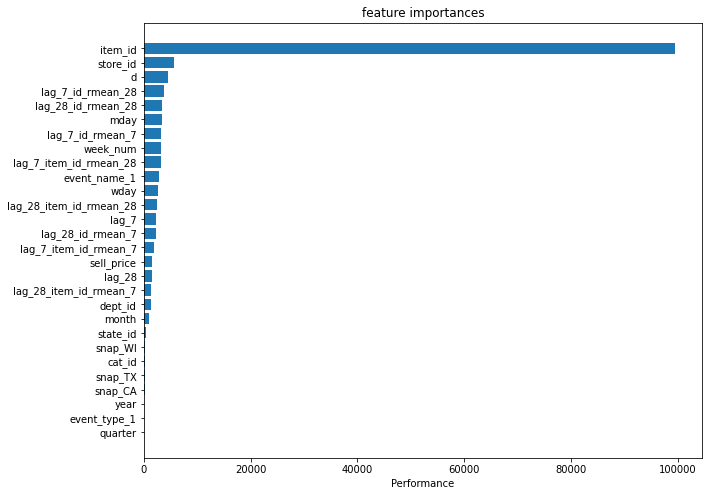

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
labels, values = [x[0] for x in feat_importances if x[1] > .5], [x[1] for x in feat_importances if x[1] > .5]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [32]:
spred = strain[strain['date'] >= VAL_DATE].copy()
preds = model.predict(spred[train_cols])
print(len(preds))
spred.loc[:, 'sales'] = preds

731760


id to draw: HOBBIES_1_261_CA_1_validation
from 2012-01-01 00:00:00 to 2016-04-24 00:00:00


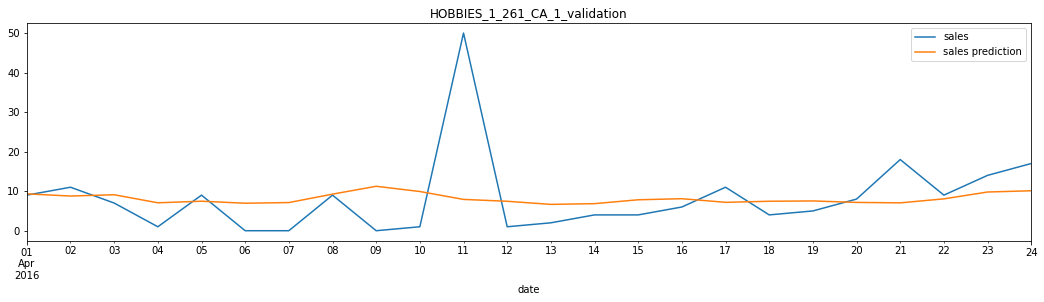

In [33]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [34]:
%%time
growth_rate = 1 #1.025
spred = get_df(is_train=False, backward_lags=BACKWARD_LAGS)
for pred_day in tqdm(range(1, 29)):
    pred_date = datetime.strptime(END_DATE, '%Y-%m-%d') + timedelta(days=pred_day)
    pred_date_back = pred_date - timedelta(days=BACKWARD_LAGS + 1)
    print('-' * 70)
    print('forecast day forward:', pred_day, '| forecast date:', pred_date) 
    spred_data = spred[(spred['date'] >= pred_date_back) & (spred['date'] <= pred_date)].copy()
    spred_data = make_features(spred_data)
    spred_data = spred_data.loc[spred['date'] == pred_date, train_cols]
    spred_data = lgbm_proc(spred_data, cat_cols)
    spred.loc[spred['date'] == pred_date, 'sales'] = growth_rate * model.predict(spred_data)

read train: (30490, 1919)
last day is: 1913
melted train: (59181090, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
date cut train: (2713610, 22)
cut train date: 2016-02-24 00:00:00
end train date: 2016-05-22 00:00:00
----------------------------------------------------------------------
forecast day forward: 1 | forecast date: 2016-04-25 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 2 | forecast date: 2016-04-26 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 3 | forecast date: 2016-04-27 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 4 | forecast date: 2016-04-28 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 5 | forecast date: 2016-04-29 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 6 | forecast date: 2016-04-30 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 7 | forecast date: 2016-05-01 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 8 | forecast date: 2016-05-02 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 9 | forecast date: 2016-05-03 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 10 | forecast date: 2016-05-04 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 11 | forecast date: 2016-05-05 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 12 | forecast date: 2016-05-06 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 13 | forecast date: 2016-05-07 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 14 | forecast date: 2016-05-08 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 15 | forecast date: 2016-05-09 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 16 | forecast date: 2016-05-10 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 17 | forecast date: 2016-05-11 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 18 | forecast date: 2016-05-12 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 19 | forecast date: 2016-05-13 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 20 | forecast date: 2016-05-14 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 21 | forecast date: 2016-05-15 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 22 | forecast date: 2016-05-16 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 23 | forecast date: 2016-05-17 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 24 | forecast date: 2016-05-18 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 25 | forecast date: 2016-05-19 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 26 | forecast date: 2016-05-20 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 27 | forecast date: 2016-05-21 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



----------------------------------------------------------------------
forecast day forward: 28 | forecast date: 2016-05-22 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)



CPU times: user 26min 5s, sys: 17.7 s, total: 26min 23s
Wall time: 22min 30s


id to draw: FOODS_3_202_CA_3_validation
from 2012-01-01 00:00:00 to 2016-05-22 00:00:00


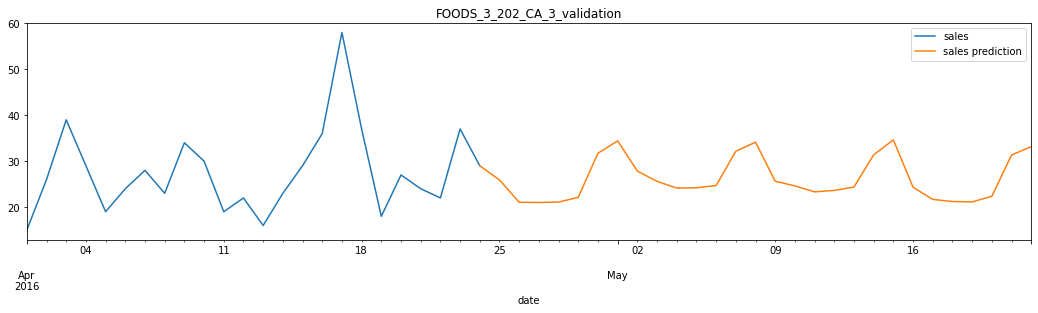

In [38]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[(spred['id'] == id_name) & (spred['date'] >= END_DATE)].set_index('date')
print('from', strain['date'].min(), 'to', spred['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [39]:
spred_subm = spred.loc[spred['date'] > END_DATE, ['id', 'd', 'sales']].copy()
last_d = int(spred.loc[spred['date'] == END_DATE, 'd'].unique()[0].replace('d_', ''))
print('last d num:', last_d)
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(int(x.replace('d_', '')) - last_d))
spred_subm['sales'].where(spred_subm['sales'] < 0, 0)
spred_subm.head()

last d num: 1913


,id,d,sales
45966979,HOBBIES_1_001_CA_1_validation,F1,0.798283
45966980,HOBBIES_1_001_CA_1_validation,F2,0.758039
45966981,HOBBIES_1_001_CA_1_validation,F3,0.794701
45966982,HOBBIES_1_001_CA_1_validation,F4,0.845800
45966983,HOBBIES_1_001_CA_1_validation,F5,0.902771


In [40]:
f_cols = ['F{}'.format(x) for x in range(1, 29)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.where(spred_subm[f_cols] < 0, 0)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.888246,0.815549,0.812976,0.804284,1.058588,1.133687,1.227694,0.943256,0.920611,1.009032,0.966043,1.068733,1.298572,1.364812,0.974207,0.925068,0.930117,0.939309,1.058946,1.294968,1.216250,0.934308,0.861053,0.848216,0.846865,1.010737,1.214165,1.202050
1,FOODS_1_001_CA_2_validation,1.060838,1.022443,1.000063,1.458514,1.371402,1.269136,1.523001,0.920003,0.953056,0.960003,0.948714,1.141943,1.577170,1.567220,1.081234,0.979610,1.004847,1.020977,1.252627,1.727467,1.567805,1.080340,1.030751,1.028724,1.087896,1.290763,1.661263,1.488288
2,FOODS_1_001_CA_3_validation,1.042835,0.991510,0.821232,0.864234,0.878729,1.016266,1.061803,0.895309,0.955567,0.813661,0.839507,0.922958,1.215259,1.225429,0.894631,0.924688,0.824985,0.843515,0.913865,1.179531,1.089585,0.838760,0.830299,0.818072,0.815054,0.907078,1.021553,0.968549
3,FOODS_1_001_CA_4_validation,0.490609,0.388494,0.363113,0.367770,0.436916,0.409784,0.468218,0.386356,0.406447,0.417475,0.406662,0.403031,0.431184,0.433049,0.349942,0.380119,0.414583,0.425755,0.466658,0.443656,0.464235,0.380684,0.401769,0.400974,0.410268,0.483824,0.458329,0.499802
4,FOODS_1_001_TX_1_validation,0.228814,0.224549,0.222582,0.237926,0.255955,0.246161,0.322305,0.370290,0.303002,0.321958,0.319526,0.329111,0.377479,0.316839,0.304452,0.335179,0.328817,0.316607,0.335633,0.320075,0.306174,0.301399,0.286213,0.309774,0.301223,0.311201,0.328026,0.316923


In [41]:
spred_subm_eval = spred_subm.copy()
spred_subm_eval["id"] = spred_subm_eval["id"].str.replace("validation", "evaluation")
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)
